In [1]:
# project : p1
# submitter : ekim322@wisc.edu
# partner : none
# hours : 4

### overview and objectives:
##### multiply tensors
##### use GPUs (when available)
##### optimize inputs to minimize outputs
##### use optimization to optimize regression coefficients

# Part 1: Prediction with Hardcoded Model

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("test.csv")

train = torch.tensor(train_csv.values, dtype = torch.float64)  # torch.Size([348, 11]) //pandas.core.frame.Dataframe
test = torch.tensor(test_csv.values, dtype = torch.float64) #  torch.Size([1044, 11])

#print(test.shape, train.shape)

In [3]:
# Requirement: your code should be written such that if torch.cuda.is_available() is true, 
# all your tensors (trainX, trainY, testX, testY, and coef) should be move to a GPU prior to any multiplication.

# trainX : number of positive COVID tests per tract, by age group
# trainY : number of positive COVID deaths per tract, by vertical, not 1 dim. ( n X 1 )

trainX = train[:,:-1]
trainY = train[:,-1:]
testX = test[:,:-1]
testY = test[:, -1:]

if torch.cuda.is_available():
    trainX = trainX.to('cuda')
    trainY = trainY.to('cuda')
    testX = testX.to('cuda')
    testY = testY.to('cuda')
        
# type(ds_train).__mro__  # torch.utils.data.dataset.TensorDataset, torch.utils.data.dataset.Dataset, typing.Generic, object)
#print("trainX \n", trainX,"\n trainY \n",trainY)
#print("testX \n", testX,"\n testY \n",testY[:10]) # just print 10 rows, because of the space of the notebook. 
#print("size :", trainX.shape, trainY.shape, testX.shape, testY.shape)
#size : torch.Size([1044, 10]) torch.Size([1044, 1]) torch.Size([348, 10]) torch.Size([348, 1])

print(trainX)
print(trainY)

tensor([[ 24.,  51.,  44.,  ...,  61.,  27.,   0.],
        [ 22.,  31., 214.,  ...,   9.,   0.,   0.],
        [ 84., 126., 239.,  ...,  74.,  24.,   8.],
        ...,
        [268., 358., 277.,  ..., 107.,  47.,   7.],
        [ 81., 116.,  90.,  ...,  36.,   9.,   0.],
        [118., 156., 197.,  ...,  19.,   0.,   0.]], dtype=torch.float64)
tensor([[3.],
        [2.],
        [9.],
        ...,
        [5.],
        [2.],
        [5.]], dtype=torch.float64)


In [4]:
# Let's predict the number of COVID deaths in the test dataset under the assumption that 
# the deathrate is 0.004 for those <60 and 0.03 for those >=60. 
# Encode these assumptions as coefficients in a tensor by pasting the following:
    
# Hardcoding version

coef = torch.tensor([
        [0.0040], # POS 0_09_CP
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP : 0.004 for <60
        [0.0300], # POS_60_69_CP : 0.03 for >=60
        [0.0300],
        [0.0300],
        [0.0300]  # POS_90 last one
], dtype=testX.dtype)
coef

tensor([[0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300]], dtype=torch.float64)

In [5]:
coef_item = (testX[0,:]@coef).item()
coef_item

9.844

# Part 2:$R^2$ Score

In [6]:
predictedY = testX@coef # check, multiplying all of testX by coef. 
predictedY[:10]

# compare predictedY to the true values in testY 
# R2 score : how much variance is a y column a model can predict(with 1 being the best score)


tensor([[ 9.8440],
        [13.8020],
        [ 3.7380],
        [ 3.6840],
        [10.9300],
        [14.7780],
        [19.4280],
        [ 6.1620],
        [ 8.6640],
        [13.9560]], dtype=torch.float64)

In [7]:
# SStot. To compute this, first compute the average testY value. 
#        Subtract to get the difference between each testY value and the average.
#        Square the differences, then add the results to get SStot

# SSreg : Subtract the prediction from testY

avg_testY = testY.mean()
SStot = ((testY - avg_testY)**2).sum()
print("SStot :", SStot)

SSreg = ((testY - predictedY)**2).sum()  # SSreg will be much smaller than SStot. 
print("SSreg :", SSreg)

improvement = SStot - SSreg
print("improvement :", improvement)

R2_score = improvement/SStot
print("R2_score :", R2_score)

#Question, is it right approach?

SStot : tensor(23463.0575, dtype=torch.float64)
SSreg : tensor(13818.9189, dtype=torch.float64)
improvement : tensor(9644.1386, dtype=torch.float64)
R2_score : tensor(0.4110, dtype=torch.float64)


In [8]:
def r2_score(true, predicted):
    """ r2_score reuable"""
    avg_true = true.mean()
    SStot = ((true - avg_true)**2).sum()
    SSreg = ((true - predicted)**2).sum()
    improvement = SStot - SSreg
    R2_score = improvement/SStot    
    
    return R2_score

In [9]:
r2_score(testY, predictedY)

tensor(0.4110, dtype=torch.float64)

# Part 3: Optimization

In [10]:
x = torch.tensor(0.0, requires_grad = True) # make us be able to track gradients, 
y = x**2 - 8*x + 19
y

tensor(19., grad_fn=<AddBackward0>)

In [17]:
# try to find a good x value. 
# The optimizer will run a loop where it computes y, 
# computes how a small change in x would effect y, 
# then makes a small change to x to try to make y smaller.

optimizer = torch.optim.SGD([x], lr=0.1)  # one or more tensors // in this case,  to find best value for x

x_line = []
y_line = []
for i in range(30):
    optimizer.zero_grad()
    y = x**2 - 8*x + 19
    y.backward()
    optimizer.step()
    print(x, y)
    
    x_line.append(x.item())
    y_line.append(y.item())

tensor(3.9960, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9968, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9975, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9980, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9984, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9987, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9990, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9992, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9993, requires_grad=True) tensor(3.0000, grad_fn=<AddBackward0>)
tensor(3.9995, requires_grad=True) tensor(3., grad_fn=<AddBackward0>)
tensor(3.9996, requires_grad=True) tensor(3., grad_fn=<AddBackward0>)
tensor(3.9997, requires_grad=True) tensor(3., grad_fn=<AddBackward0>)
tensor(3.9997, requires_grad=True) tensor(3., grad_fn=<AddBackward0>)
tensor(3.9998, requires_grad=True) tensor(3., grad_fn=

In [18]:
x.item()

3.9999938011169434

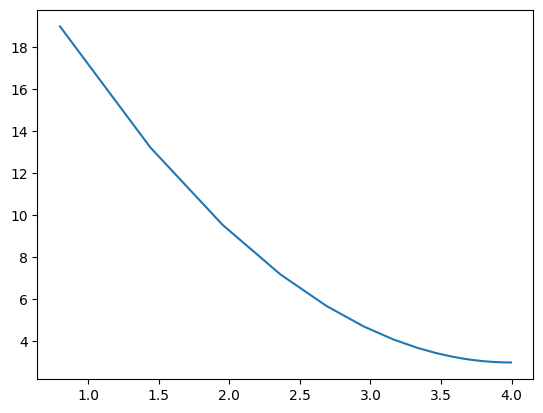

In [12]:
#TODO : creat a line plot of x and y / to check if x is right value
plt.plot(x_line, y_line)  # batch : can't call np() on Tensor, 

# Part 4: Linear Regression

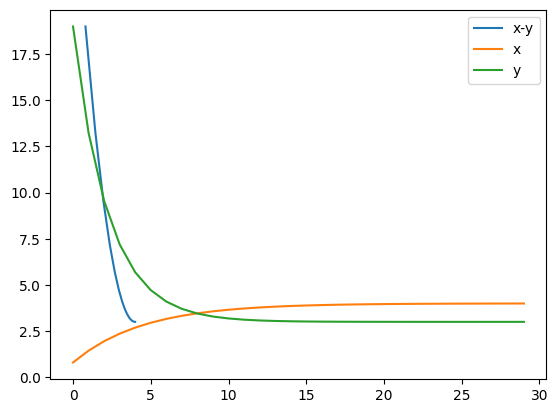

In [13]:
plt.plot(x_line, y_line, label = "x-y")
plt.plot(x_line, label = "x")
plt.plot(y_line, label = "y")
plt.legend()

In [14]:
ds = torch.utils.data.TensorDataset(trainX, trainY)
dl = torch.utils.data.DataLoader(ds, shuffle = True, batch_size = 11) # use shuffle,

#ds # <torch.utils.data.dataset.TensorDataset at 0x7f1b2f5ba980>
#dl # <torch.utils.data.dataloader.DataLoader at 0x7f1b2ef28220>

#TODO : try batch sizes and decide the size. (try : 3, 10, 11)

for batchx, batchy in dl:
    print(batchx) # torch.float64 (input)
    print(batchy)
    break

tensor([[103., 154., 328., 277., 171., 150.,  88.,  41.,  15.,   0.],
        [154., 189., 299., 285., 200., 135.,  96.,  23.,  13.,   0.],
        [176., 270., 244., 302., 277., 275., 202.,  92.,  35.,  12.],
        [128., 192., 179., 213., 244., 274., 227., 139.,  59.,  10.],
        [ 93., 125., 128., 159., 103.,  86.,  56.,  17.,   0.,   0.],
        [ 96., 169., 176., 193., 187., 159., 140.,  79.,  55.,  18.],
        [ 64., 104., 157., 194., 144., 132., 111.,  45.,  14.,   5.],
        [111., 156., 249., 241., 168., 171., 153.,  27.,  10.,   0.],
        [ 57.,  53., 101., 102.,  78.,  72.,  73.,  55.,  35.,  15.],
        [ 49., 142.,  72.,  98., 135., 157., 135.,  72.,  28.,   0.],
        [105., 135., 166., 213., 201., 192., 151.,  90.,  21.,   0.]],
       dtype=torch.float64)
tensor([[ 0.],
        [ 9.],
        [18.],
        [ 9.],
        [ 4.],
        [15.],
        [ 5.],
        [ 5.],
        [ 9.],
        [ 7.],
        [ 6.]], dtype=torch.float64)


In [15]:
print(trainX.shape) #torch.Size([1044, 10])
print(trainY.shape) #torch.Size([1044, 1])

torch.Size([1044, 10])
torch.Size([1044, 1])


In [16]:
# 1. choose model size based on size X, Y : 10, 1
# 2. try and choose lr. : 0.1, 0.01, 0.001, 0.0001 ~ 0.0000005, 0.0000001, 
# 3. try and choose epoch : 30, 50, 60, 70, 80, 90, 100
# 4. try and choose batch size : 3, 10, 11

model = torch.nn.Linear(10,1) #  # choose the size based on X, Y [1044, 10], [1044, 1]

model.weight.data = model.weight.data.to(torch.float64) # debug : # mat1 and mat2 must have the same dtype / input to the linear(torch.float64) / weight matrix for the module(
model.bias.data = model.bias.data.to(torch.float64)   # print(model.weight.dtype, model.bias.dtype) # float.32 -> 64


optimizer = torch.optim.SGD([model.weight, model.bias], lr = 0.0000005)  
                                                       # TODO : choose lr. 
                     # this will optimize the model.weight, model.bias parameters 

loss_fn = torch.nn.MSELoss()

start = time.time()

# TODO : write a training loop with trying differnet "numbers of epochs"
for epoch in range(50):  # try : 
    for batchx, batchy in dl:
        predictedy = model(batchx) 
        loss = loss_fn(batchy, predictedy)
        #change model params based on loss. 
        loss.backward()      # update wiehgt.grad and bias.grad
        optimizer.step()     # update weight and bias based on the gradients, 
        optimizer.zero_grad() # weight.grad = 0 and bias.grad = 0
        # change model params based on loss
    # how well are we doing
    x, y = ds_train[:]
    print(epoch, loss_fn(y, model(x))) # loss_fn(real Y, predicted Y)
# calcuate torch.nn.MSELoss with "loss_fn = torch.nn.MSELoss(), we already defined. 

end = time.time()

# TODO : report r2_score > 0.5
print("\nResult")
print("R2_score :", r2_score(batchy, predictedy).item())

# TODO : print how long training took 
how_long = end - start
print("It took", how_long, "sec")

# TODO : creat a bar plot, showing each of the numbers in the model.wiehgt tensor. 
   # x-axis : column nmaes, each coeficeint(from train.columns.)
    
# plot.bar(model.weight / columns, coeficient from train)

NameError: name 'ds_train' is not defined

In [ ]:
labels = train_csv.columns[:-1].tolist()
new_labels = [x.split("_")[1]+"_"+x.split("_")[2] for x in labels]
new_labels
new_labels[-1] = '90_'

In [ ]:
model.weight.detach().numpy()

In [ ]:
# TODO : creat a bar plot, showing each of the numbers in the model.wiehgt tensor. 
   # x-axis : column nmaes, each coeficeint(from train.columns.)

plt.bar(new_labels, model.weight.detach().numpy()[0])
plt.show()

# Mismatch is between arg 0 with shape (11,) and arg 1 with shape (1, 10).

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()